In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the dataset
df = pd.read_csv('./sales_data_sample.csv', encoding='unicode_escape')



In [3]:
# Columns to Remove
to_drop = ['ADDRESSLINE1', 'ADDRESSLINE2', 'STATE', 'POSTALCODE', 'PHONE']
df = df.drop(to_drop, axis=1)

In [4]:
# Convert ORDERDATE to datetime
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

In [5]:
# Calculate Recency, Frequency, and MonetaryValue
snapshot_date = df['ORDERDATE'].max() + pd.Timedelta(days=1)
df_RFM = df.groupby(['CUSTOMERNAME']).agg({
    'ORDERDATE': lambda x: (snapshot_date - x.max()).days,
    'ORDERNUMBER': 'count',
    'SALES': 'sum'
})

In [6]:
# Rename columns
df_RFM.rename(columns={
    'ORDERDATE': 'Recency',
    'ORDERNUMBER': 'Frequency',
    'SALES': 'MonetaryValue'
}, inplace=True)

In [7]:
# Create quartile ranges for M, R, and F
df_RFM['M'] = pd.qcut(df_RFM['MonetaryValue'], q=4, labels=range(1, 5))
df_RFM['R'] = pd.qcut(df_RFM['Recency'], q=4, labels=list(range(4, 0, -1)))
df_RFM['F'] = pd.qcut(df_RFM['Frequency'], q=4, labels=range(1, 5))


In [8]:
# Calculate RFM Score
df_RFM['RFM_Score'] = df_RFM[['R', 'M', 'F']].sum(axis=1)


In [9]:
# Define customer segments
def rfm_level(df):
    if df['RFM_Score'] >= 10:
        return 'High Value Customer'
    elif 6 <= df['RFM_Score'] < 10:
        return 'Mid Value Customer'
    else:
        return 'Low Value Customer'

df_RFM['RFM_Level'] = df_RFM.apply(rfm_level, axis=1)

In [10]:
# Prepare the data for K-Means clustering
data = df_RFM[['Recency', 'Frequency', 'MonetaryValue']]
data_log = np.log1p(data)

In [11]:
# Standardize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_log)

C:\Users\Anisha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Anisha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Anisha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Anisha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the envir

C:\Users\Anisha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Anisha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Anisha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Anisha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the envir

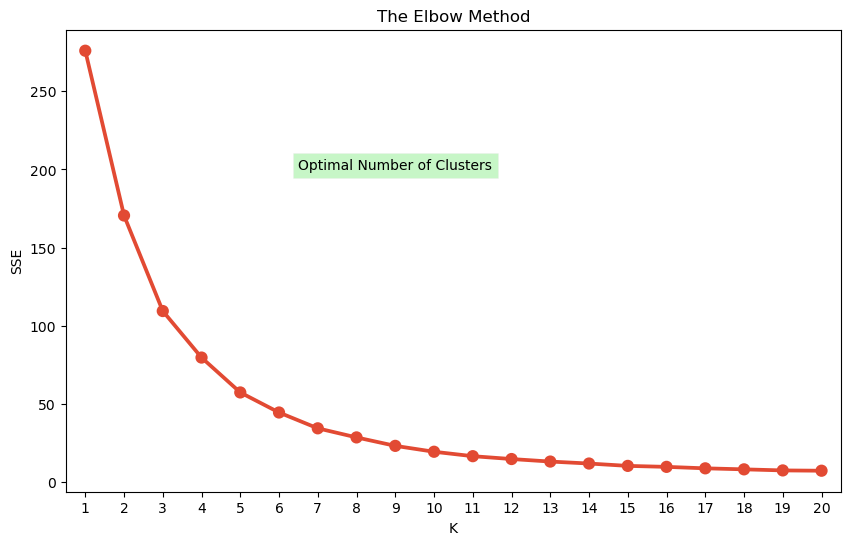

In [12]:
# Find the optimal number of clusters using the Elbow Method
sse = {}
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(data_normalized)
    sse[k] = kmeans.inertia_

plt.figure(figsize=(10, 6))
plt.title('The Elbow Method')
plt.xlabel('K')
plt.ylabel('SSE')
plt.style.use('ggplot')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.text(5.5, 200, "Optimal Number of Clusters", bbox=dict(facecolor='lightgreen', alpha=0.5))
plt.show()

In [13]:
# Based on the elbow method, choose the number of clusters (e.g., 5)
num_clusters = 5

In [16]:
# Apply K-Means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=1)
kmeans.fit(data_normalized)
cluster_labels = kmeans.labels_

C:\Users\Anisha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Anisha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [17]:
# Add cluster labels to the original data
data_rfm = data.assign(Cluster=cluster_labels)
data_rfm.head()

,Recency,Frequency,MonetaryValue,Cluster
CUSTOMERNAME,,,,
"AV Stores, Co.",196,51,157807.81,4
Alpha Cognac,65,20,70488.44,2
Amica Models & Co.,265,26,94117.26,2
"Anna's Decorations, Ltd",84,46,153996.13,4
Atelier graphique,188,7,24179.96,1
